# Convolutional Neural Network in TensorFlow

## 1.1 Introduction

In deep learning, a convolutional neural network (CNN, or ConvNet) is a class of deep neural networks, most commonly applied to analyzing visual imagery.

Convolutional networks were inspired by biological processes in that the connectivity pattern between neurons resembles the organization of the animal visual cortex. Individual cortical neurons respond to stimuli only in a restricted region of the visual field known as the receptive field. The receptive fields of different neurons partially overlap such that they cover the entire visual field.

<img src="images/08_cnn_model.png">
<br><br>
A CNN consists of following layers:
<ol>
    <li>Input layer</li>
    <li>Convolution layer</li>
    <li>Pooling layer</li>
    <li>Activation layer</li>
    <li>Regularization layer</li>
    <li>Fully Connected layer</li>
    <li>Output layer</li>
</ol>

## 1.2 Input Layer

<img src="images/08_input_image.png">
INPUT LAYER will hold the raw pixel values of the image with three color channels R,G,B.

## 1.3 Convolution Layer

Convolutional layers apply a convolution operation to the input, passing the result to the next layer. The convolution emulates the response of an individual neuron to visual stimuli.
<img src="images/08_conv_op.png">

<ul>
    <li>Convolution is an procedure in which a filter or kernel slide over the complete image and along the way take the dot product between the filter and chunks of the input image. When this operation is complete we get another set of feature maps.</li>
    <li>The sliding of the filter is determined by the stride value, by default use a stride value of 1.</li>
    <li>The values of the filter changes with each iteration over the training set, indicating that network is learning.</li>
</ul>

## 1.4 Pooling Layer
<img src="images/08_maxpool_op.png">

A pooling layer is another building block of a CNN.
<ul>
    <li>Its function is to reduce the spatial size of the representation to reduce the amount of parameters and computation in the network.</li>
    <li>Pooling layer operates on each feature map independently.</li>
    <li>Two most commonly used pooling are - Max Pooling and Mean Pooling.</li>
</ul>

## 1.5 Activation Layer

<ul>
    <li>The activation layer controls how the signal flows from one layer to the next, emulating how neurons are fired in our brain.</li>
    <li>The activation layer introduces the non-linearity into the network, which helps the network to learn more complex behaviour.</li>
    <li>CNN is compatible with a wide variety of complex activation functions to model signal propagation, the most common function being the Rectified Linear Unit (ReLU), which is favored for its faster training speed.</li>
</ul>

<img src="images/08_relu_f.png">
<img src="images/08_relu_op.jpeg">

## 1.6 Regularization Layer

Regularization adds a penalty on the different parameters of the model to reduce the freedom of the model. Hence, the model will be less likely to fit the noise of the training data and will improve the generalization abilities of the model.
<img src="images/08_dropout_op.png">

We are going to use Dropout for regularization.
<ul>
    <li>Dropout forces a neural network to learn multiple independent representations of the same data by alternately randomly disabling neurons in the learning phase.</li>
    <li>Dropout is an important feature in almost every state-of-the-art neural network implementation.</li>
    <li>To perform dropout on a layer, you randomly set some of the layer's values to 0 during forward propagation.</li>
    <li>Dropout is used only during training phase, we don't use it in the testing phase.</li>
</ul>

## 1.7 Fully Connected Layer

<ul>
    <li>After a specific number of Conv -> Relu -> Pooling operations, we flatten the feature maps and introduce the fully connected or dense layer. </li>
    <li> We use the fully connected layer for the classification purpose.</li>
</ul>

## 1.8 Output Layer

To get the output, we apply a Softmax function to the fully connected layer.
<img src="images/08_softmax_op.png">

## 1.9 Loss function
For the loss function, we are going to use the Cross Entropy.

## 1.10 Optimization
For the optimization, we are going to Adam Optimizer.

## 1.11 Dataset
We are going to use Fashion MNIST Dataset

## 1.12 Code

### Imports

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

print(tf.__version__)

1.12.0


### Dataset

In [2]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train),(x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

Shape of Images:  (60000, 28, 28)
Shape of Labels: (60000,)


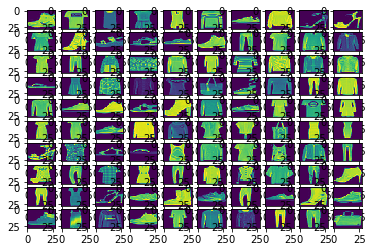

In [3]:
print("Shape of Images: ", x_train.shape)
print("Shape of Labels:" , y_train.shape)

fig,ax = plt.subplots(10,10) 
k = 0
for i in range(10): 
    for j in range(10): 
        ax[i][j].imshow(x_train[k], aspect='auto') 
        k += 1
plt.show()

### Hyperparameters

In [4]:
learning_rate = 0.0001
training_epochs = 5
batch_size = 32
display_step = 1

n_input = 28
n_output = 10

### One Hot Encoding

In [5]:
def to_onehot(y):
    data = np.zeros((n_output), np.float32)
    data[y] = 1.0
    return data

x_train = np.reshape(x_train, (-1, n_input, n_input, 1))
x_test = np.reshape(x_test, (-1, n_input, n_input, 1))

y_train = np.array([to_onehot(y) for y in y_train])
y_test = np.array([to_onehot(y) for y in y_test])

print(x_train.shape, y_train.shape)

(60000, 28, 28, 1) (60000, 10)


### Placeholders

In [6]:
# tf Graph input
X = tf.placeholder(tf.float32, [None, n_input, n_input, 1], name="Input")
Y = tf.placeholder(tf.float32, [None, n_output], name="Output")
keep_prob = tf.placeholder(tf.float32, name="Dropout") # dropout (keep probability)

### Conv2D

In [7]:
def conv2d(x, kernel=3, filters=32, strides=1):
    input_ch = x.shape[-1].value
    W = tf.Variable(tf.random_normal([kernel, kernel, input_ch, filters]) * tf.sqrt(2/filters))
    b = tf.Variable(tf.zeros([filters]))
    
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

### MaxPool2D

In [8]:
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

### Flatten

In [9]:
def flatten(x):
    flat = x.shape[1].value * x.shape[2].value * x.shape[3].value
    return tf.reshape(x, shape=[-1, flat])

### Dense Layer

In [10]:
def dense(x, units):
    W = tf.Variable(tf.random_normal([x.shape[-1].value, units]) * tf.sqrt(2/units))
    b = tf.Variable(tf.zeros([units]))
    return tf.matmul(x, W) + b

### CNN

In [11]:
def conv_net(x, dropout, summary=True):
    summary_data = []
    summary_data.append(x.shape)
    
    conv1 = conv2d(x, kernel=3, filters=16)
    summary_data.append(conv1.shape)
    
    pool1 = maxpool2d(conv1, k=2)
    summary_data.append(pool1.shape)
    
    conv2 = conv2d(pool1, kernel=3, filters=32)
    summary_data.append(conv2.shape)
    
    pool2 = maxpool2d(conv2, k=2)
    summary_data.append(pool2.shape)
    
    flat = flatten(pool2)
    flat = tf.nn.dropout(flat, dropout)
    summary_data.append(flat.shape)
    
    fc1 = tf.nn.relu(dense(flat, 512))
    fc1 = tf.nn.dropout(fc1, dropout)
    summary_data.append(fc1.shape)
    
    fc2 = dense(fc1, n_output)
    summary_data.append(fc2.shape)
    
    if summary == True:
        for shape in summary_data:
            print(shape)
    
    return fc2

### Construct model

In [12]:
logits = conv_net(X, keep_prob)
prediction = tf.nn.softmax(logits)

(?, 28, 28, 1)
(?, 28, 28, 16)
(?, 14, 14, 16)
(?, 14, 14, 32)
(?, 7, 7, 32)
(?, 1568)
(?, 512)
(?, 10)


### Define loss and optimizer

In [13]:
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

### Calculate Accuracy

In [14]:
def accuracy(predictions, labels): 
    correctly_predicted = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) 
    acc = (100.0 * correctly_predicted) / predictions.shape[0] 
    return acc

### Training

In [15]:
# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.0
        avg_acc = 0.0
        total_batch = len(x_train)//batch_size
        
        for i in range(total_batch):
            batch_x = x_train[i:i+1*batch_size]
            batch_y = y_train[i:i+1*batch_size]
            
            _, c = sess.run([train_op, loss_op], feed_dict={X: batch_x, Y: batch_y, keep_prob: 0.5})
            avg_cost += c/total_batch
            
            pred_y = sess.run(prediction, feed_dict={X: batch_x, keep_prob: 1.0})
            acc = accuracy(pred_y, batch_y)
            avg_acc += acc/total_batch
            
            
        if (epoch+1) % display_step == 0:
            test_loss, pred_y = sess.run([loss_op, prediction], feed_dict={X: x_test, Y: y_test, keep_prob: 1.0})
            test_acc = accuracy(pred_y, y_test)
            
            print("Epoch: {:2.0f} - Loss: {:3.5f} - Acc: {:2.5f} - Test Loss: {:3.5f} - Test Acc: {:2.5f}".format(
                epoch+1, avg_cost, avg_acc, test_loss, test_acc))
            
    print("Optimization Finshed")
    
    # Test model
    correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Test Accuracy:", acc.eval({X: x_test, Y: y_test, keep_prob: 1.0}))

Epoch:  1 - Loss: 4.34493 - Acc: 77.66167 - Test Loss: 0.67176 - Test Acc: 76.51000
Epoch:  2 - Loss: 0.80169 - Acc: 86.63000 - Test Loss: 0.59945 - Test Acc: 79.84000
Epoch:  3 - Loss: 0.52163 - Acc: 91.30500 - Test Loss: 0.52777 - Test Acc: 81.76000
Epoch:  4 - Loss: 0.38267 - Acc: 94.72500 - Test Loss: 0.48936 - Test Acc: 82.80000
Epoch:  5 - Loss: 0.28146 - Acc: 97.12333 - Test Loss: 0.48314 - Test Acc: 83.10000
Optimization Finshed
Test Accuracy: 0.831
